In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_sentenceattribution_nerfeatures_split.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","entity_map_ev","entity_ev","synonym","voice","split"],skiprows=1)

Using custom data configuration default-cfbf7584a6bb7c13
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 361.24it/s]


In [3]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-aa1fd4d2889f655e.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9cd628f4430f2ace.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-df968f39da4ad12a.arrow


In [4]:
columns_to_keep = ["claim", "premise", "label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 

In [6]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-3939f688401dfd1d.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-6e3e675e2ac00106.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ec7578b7af56fb7d.arrow


Label Encoding Mapping: {'contradiction': 2, 'entailment': 0, 'neutral': 1}


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 

In [8]:
labels = np.array(dataset['train']['label'])

In [9]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name="bioformers/bioformer-8L-mnli"):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        claim = item['claim'] 
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        additional_features = [
            "counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat"]
    
        for feature in additional_features:
            if feature in item:
                evidences += "[SEP]" + str(item[feature])
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
         # Construct the output item
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': evidences  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item



In [10]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [11]:
model_name = "bioformers/bioformer-8L-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32768, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

In [13]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
    num_rows: 1623
})

In [14]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [15]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [16]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [17]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [18]:
tdata.__getitem__(0)

{'input_ids': tensor([  101,  4916,   117,  5545,  5029,  8349,  2290,  3047,  4506,  1975,
          1488,  1425,  2132,  4765,  2848,  9507,  1111,  1435,  2573,  1109,
          4258,  3720,  6187,  3004,  2076,  4989,  1425,  8635,  1431, 17188,
          1560,  3550, 14180,  1446, 19612,  1520,  2911,  3550,  2290,  3047,
           119,   102,   121,   102,   121,   102,   121,   102,   121,   102,
           121,   102,   121,   102,   121,   102,   121,   102,   121,   102,
           121,   102,   121,   102,   121,   102, 31487,  4258,  3720,  6187,
          1478,  8811,  1822,  1427,  3550,  5183,  4030,  1446,  3346,  2520,
          1425,  6875,  1431,  1425,  3550,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [19]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/11.1.4_bioformer/',
    num_train_epochs=15,
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/11.1.4_bioformer/best_model')
tokenizer.save_pretrained(f'/home/elson/11.1.4_bioformer/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.728300,0.903474,0.612903,0.577434,0.612903,0.563043
2,0.649900,0.839004,0.638710,0.619164,0.638710,0.623247
3,0.380300,0.956364,0.638710,0.621424,0.638710,0.627735
4,0.284900,1.162364,0.640860,0.632653,0.640860,0.635536
5,0.272200,1.245507,0.623656,0.641006,0.623656,0.630194
6,0.182900,1.341134,0.643011,0.648485,0.643011,0.645295
7,0.146000,1.494808,0.638710,0.638742,0.638710,0.638662
8,0.097200,1.635426,0.619355,0.623415,0.619355,0.620957
9,0.054600,1.725008,0.630108,0.626107,0.630108,0.626730
10,0.046700,1.828573,0.625806,0.622938,0.625806,0.624320


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/11.1.4_bioformer/checkpoint-51
Configuration saved in /home/elson/11.1.4_bioformer/checkpoint-51/config.json
Model weights saved in /home/elson/11.1.4_bioformer/checkpoint-51/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/11.1.4_bioformer/checkpoint-102
Configuration saved in /home/elson/11.1.4_bioformer/checkpoint-102/config.json
Model weights saved in /home/elson/11.1.4_bioformer/checkpoint-102/pytorch_model.bin
Deleting older checkpoint [/home/elson/11.1.4_bioformer/checkpoint-51] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/11.1.4_bioformer/checkpoint-153
Configuration saved in /home/elson/11.1.4_bioformer/checkpoint-153/config.json
Model weights saved in /home/elson/11.1.4_bioformer/checkpoint-153/pytorc

Configuration saved in /home/elson/11.1.4_bioformer/best_model/config.json
Model weights saved in /home/elson/11.1.4_bioformer/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/11.1.4_bioformer/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/11.1.4_bioformer/best_model/special_tokens_map.json


('/home/elson/11.1.4_bioformer/best_model/tokenizer_config.json',
 '/home/elson/11.1.4_bioformer/best_model/special_tokens_map.json',
 '/home/elson/11.1.4_bioformer/best_model/vocab.txt',
 '/home/elson/11.1.4_bioformer/best_model/added_tokens.json',
 '/home/elson/11.1.4_bioformer/best_model/tokenizer.json')

In [20]:
model_path = "/home/elson/11.1.4_bioformer/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/11.1.4_bioformer/best_model/config.json
Model config BertConfig {
  "_name_or_path": "/home/elson/11.1.4_bioformer/best_model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "mnli",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_siz

In [21]:
print(test_results)

PredictionOutput(predictions=array([[ 2.25   ,  0.6675 , -3.195  ],
       [ 4.22   , -1.648  , -2.838  ],
       [ 2.537  ,  0.2227 , -3.023  ],
       [-2.605  ,  2.482  ,  0.3777 ],
       [ 2.379  ,  0.759  , -3.13   ],
       [ 4.05   , -1.738  , -2.512  ],
       [ 4.     , -2.143  , -2.201  ],
       [ 4.094  , -1.874  , -2.459  ],
       [ 2.572  ,  0.1106 , -3.08   ],
       [ 1.399  ,  1.032  , -2.697  ],
       [ 3.799  , -2.867  , -1.187  ],
       [ 4.223  , -2.129  , -2.336  ],
       [-3.693  ,  0.7983 ,  3.195  ],
       [ 4.05   , -1.807  , -2.445  ],
       [ 0.348  ,  0.1815 , -0.488  ],
       [-1.866  ,  1.88   , -0.194  ],
       [ 4.2    , -1.638  , -2.855  ],
       [ 4.105  , -1.318  , -2.95   ],
       [ 4.195  , -2.219  , -2.27   ],
       [ 4.133  , -1.862  , -2.545  ],
       [ 2.373  , -0.548  , -2.102  ],
       [ 3.285  , -0.479  , -3.307  ],
       [-1.059  ,  3.557  , -2.484  ],
       [-0.1327 ,  1.741  , -1.799  ],
       [-1.018  , -0.984  ,  2.158 

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)

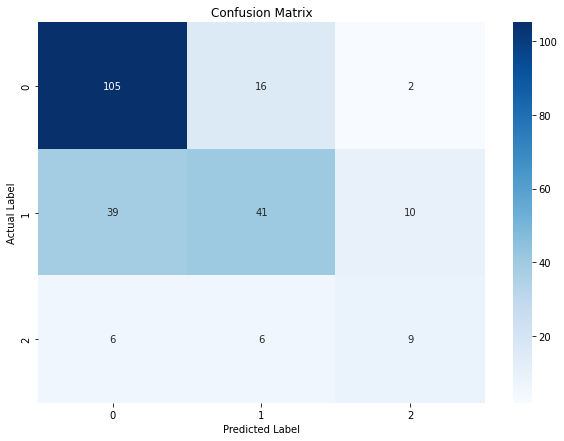

In [24]:
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Adjust xticklabels and yticklabels as needed
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


In [25]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)


# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/11.1.4_results.csv', index=False)

In [26]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [27]:
correct_classification_counts

General Health           37
Skin                     14
Bone health              13
Diabetes                 11
Cancer                   11
Fitness                   9
Cardiovascular Health     8
Hair                      7
Eye                       7
Ear                       6
Neurological health       6
Throat                    5
COVID                     4
Blood                     4
Mental Health             3
Men's health              3
Vascular                  2
Women' s Health           2
Muscles                   2
Dental Health             1
Name: Category, dtype: int64

In [28]:
misclassification_counts

General Health           14
Skin                     10
Bone health               8
Fitness                   6
Blood                     5
Hair                      5
Women' s Health           4
Muscles                   4
Throat                    4
Cardiovascular Health     4
Neurological health       3
Men's health              3
Eye                       2
Dental Health             2
COVID                     2
Vascular                  1
Cancer                    1
Diabetes                  1
Name: Category, dtype: int64